## I can grab the history data from the start by potentially using selenium to scrape the site

In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common import by
from selenium.webdriver.support.ui import WebDriverWait
import re
from datetime import timedelta, datetime

parent_xpath = '//*[@id="app-main"]/div[4]/div[2]/div[1]/div/div[2]/div/*'
initial_record_xpath = "//*[contains(text(), 'The first time recorded was')]/span/span/span/span/span"
record_history = []
date_history = []
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))
wait = WebDriverWait(driver, 3)

driver.get('https://www.speedrun.com/MKWorld')
button = driver.find_element(by.By.XPATH, '//span[text()="History"]')
button.click()
wait.until(lambda d: len(d.find_elements(by.By.XPATH, parent_xpath)) > 12)
first_record = driver.find_element(by.By.XPATH, initial_record_xpath)

# convert to timedelta
match = re.match(r'(?:(\d+)h)?\s*(?:(\d+)m)?\s*(?:(\d+)s)?', first_record.text)
if match:
    hours = int(match.group(1)) if match.group(1) else 0
    mins = int(match.group(2)) if match.group(1) else 0
    sec = int(match.group(3)) if match.group(1) else 0
else:
    print('Something went wrong, format was not recognized')

first_world_record = timedelta(hours=hours, minutes=mins, seconds=sec)
record_history.append(first_world_record)

print(first_world_record)


/Users/a266490/Documents/data_analysis/mario_kart_world/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


2:01:24


## ^ So the above can work, What I will do is I will grab the very first record, Then from there I will use another code block to grab the entire history as they are not the same tags

In [2]:

parent_xpath = "//*[contains(text(), 'set a new record time of') or contains(text(), 'improved their time to')]"
date_parent_xpath = '//*[@id="app-main"]/div[4]/div[2]/div[1]/div/div[2]/div'
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))
wait = WebDriverWait(driver, 3)

driver.get('https://www.speedrun.com/MKWorld')
button = driver.find_element(by.By.XPATH, '//span[text()="History"]')
button.click()
wait.until(lambda d: len(d.find_elements(by.By.XPATH, parent_xpath)) > 12)
record_list = driver.find_elements(by.By.XPATH, parent_xpath)
date_list = driver.find_elements(by.By.XPATH, parent_xpath)
# //*[@id="app-main"]/div[4]/div[2]/div[1]/div/div[2]/div/div/div[2]/div[1]/div[2]

# this to get all the dates except the one that does not matter: //*[@id="app-main"]/div[4]/div[2]/div[1]/div/div[2]/div/div/div[2]/div[1]/div[2][preceding-sibling::div[1][not(contains(., "Mario Kart World was released"))]]

for span in record_list:
    time_entry = None
    try:
        time_entry = span.find_element(by.By.XPATH, './span/span/span/span/span')
    except:
        print('No Element error')
        continue

    # convert to timedelta
    match = re.match(r'(?:(\d+)h)?\s*(?:(\d+)m)?\s*(?:(\d+)s)?', time_entry.text)
    if match:
        hours = int(match.group(1)) if match.group(1) else 0
        mins = int(match.group(2)) if match.group(1) else 0
        sec = int(match.group(3)) if match.group(1) else 0
    else:
        print('Something went wrong, format was not recognized')
    time = timedelta(hours=hours, minutes=mins, seconds=sec)
    record_history.append(time)

print(len(record_history))
    
                    





# first_world_record = timedelta(hours=hours, minutes=mins, seconds=sec)

# print(first_world_record)

No Element error
17


## Here I am going to grab the dates that the records were set

In [3]:

parent_xpath = ' //*[@id="app-main"]/div[4]/div[2]/div[1]/div/div[2]/div/div/div[2]/div[1]/div[2][preceding-sibling::div[1][not(contains(., "Mario Kart World was released"))]]'
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))
wait = WebDriverWait(driver, 3)

driver.get('https://www.speedrun.com/MKWorld')
button = driver.find_element(by.By.XPATH, '//span[text()="History"]')
button.click()
wait.until(lambda d: len(d.find_elements(by.By.XPATH, parent_xpath)) > 12)
date_list = driver.find_elements(by.By.XPATH, parent_xpath)


for span in date_list:
    time_entry = None
    date_string = re.match(r'(\d{4})-(\d{2})-(\d{2})', span.text)
    date_object = datetime.strptime(date_string.group(0), "%Y-%m-%d")
    date_history.append(date_object)
print(len(date_history))

17


# Plotting the time series

In [4]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import datetime

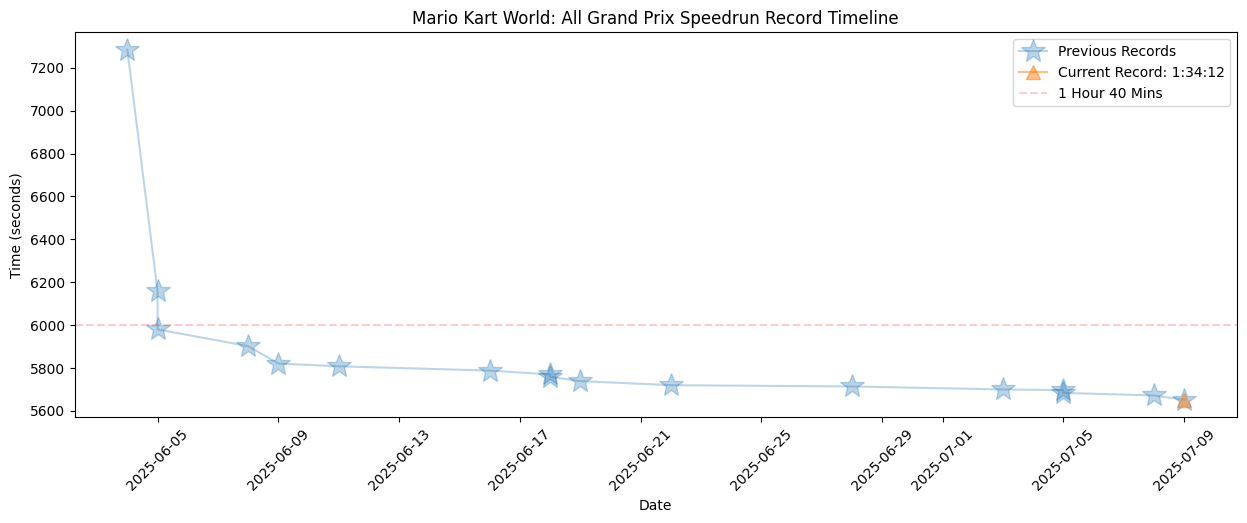

In [5]:
record_history_in_seconds = [x.total_seconds() for x in record_history]
fastest_index = record_history_in_seconds.index(min(record_history_in_seconds))
fastest_date = date_history[fastest_index]
fastest_time = record_history_in_seconds[fastest_index]

total_secs = int(fastest_time)
hours, remainder = divmod(total_secs, 3600)
minutes, secs = divmod(remainder, 60)
fastest_time_label = f'{hours}:{minutes:02}:{secs:02}'



plt.figure(figsize=(15,5))

plt.plot(date_history, record_history_in_seconds, marker=r'*', markersize=18, alpha=0.3, label='Previous Records')
plt.plot(fastest_date, fastest_time, marker=r'^', markersize=10, alpha=0.5, label='Current Record: ' + fastest_time_label)
plt.ylabel('Time (seconds)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Mario Kart World: All Grand Prix Speedrun Record Timeline')
plt.axhline(y=6000, color='red', linestyle='--', alpha=0.2, label='1 Hour 40 Mins')


plt.legend( loc='upper right')
plt.legend()
plt.show()